## Imports

In [1]:
import numpy as np
import scipy.stats
from scipy.stats import norm, truncnorm,binom
from scipy.io import loadmat

import pickle
import imp
import sys

sys.path.append('../code/')

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline

In [2]:
# gridworld simulation code 
import task_gridworld
imp.reload(task_gridworld)
from task_gridworld import Task_GridWorld

import task_utils
imp.reload(task_utils)
from task_utils import idcs2state,state2idcs,action_str_to_num

In [3]:
# code for calculating cvar-optimal policies (and values)
import dp
imp.reload(dp)
from dp import CVaR_DP

In [4]:
# code for evaluating policies (i.e. generating behavioral trajectories) in the gridworld
import mcmc_eval
imp.reload(mcmc_eval)
from mcmc_eval import run_simulation, calc_V_CVaR_MCMC

In [5]:
# plotting code 
import plotting
imp.reload(plotting)
from plotting import plot_policy

## (Panel a) Plotting Random Policy

In [6]:
# instantiate task 
task = Task_GridWorld()

In [7]:
Pol = np.ones((12,2))*0.5
V = np.zeros(12)
core_states =  [0,1,2,3,4,5,6,7,8,9,10,11]

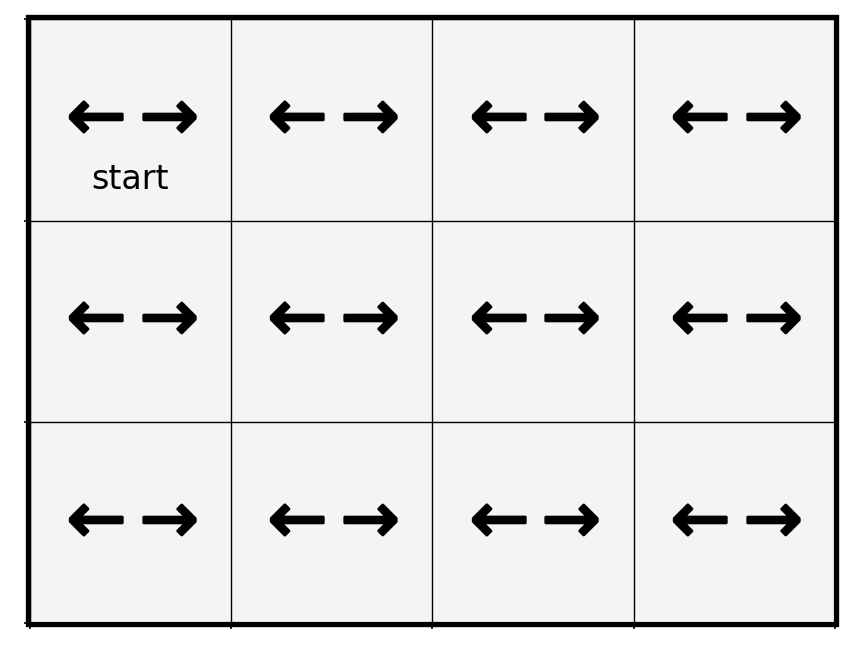

In [8]:
plot_policy(task,V,Pol,core_states,Alpha=None,asym_color=False,ms=20)

## (Panel b): Optimal Policies

### Some shared parameters

In [24]:
# interpolation values for alpha 
alpha_set = np.array([0.        , 0.01      , 0.01274275, 0.01623777, 0.02069138,
       0.02636651, 0.03359818, 0.04281332, 0.05455595, 0.06951928,
       0.08858668, 0.11288379, 0.14384499, 0.18329807, 0.23357215,
       0.29763514, 0.37926902, 0.48329302, 0.61584821, 0.78475997,
       1.        ])

# planning horizon 
T = 40

### PCVaR

#### Calculate Optimal Policy

In [25]:
# instantiate task 
task = Task_GridWorld()

In [26]:
# calculate optimal policy (working backwards from last timestep)
results = CVaR_DP(task,
                  T= T,
                  alpha_set = alpha_set,
                  cvar_type='pCVaR',
                  parallel=True)

t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0


#### Filename

In [70]:
savename= '../results/task_gridworld_pCVaR_T='+str(T)+'_21_alphaset.npz'
print(savename)

../results/task_gridworld_pCVaR_T=40_21_alphaset.npz


#### Save

In [71]:
np.savez_compressed(savename,results=results,allow_pickle=True)

#### Load

In [72]:
loaded = np.load(savename,allow_pickle=True)
results = loaded['results'].tolist()

In [73]:
policy_to_evaluate = results['pi'].copy()

#### Sample Trajectories from Optimal Policy

In [67]:
s0 = 0
Nsims=20000
Nsims=5000 # takes less time and space
alpha0 = 0.18329807 # which alpha to start with for pCVaR

# get alpha indicator 
alpha0_i = np.where(alpha_set==alpha0)[0][0]

# run the MCMC for the changing policy 
results_mcmc = run_simulation(task,
                               results['pi'].copy(),  # must be states x actions x alphas x time-steps
                               T=T,
                               Nsims = Nsims,
                               s0 = s0,
                               alpha_i0= alpha0_i,
                               alpha_set = alpha_set,
                               Xis=results['Xis'],
                               adjust_alpha=True, # important for pCVaR
                              )  

#### Save Trajectories

In [68]:
savename_mcmc = savename.replace('.p','_mcmc.p')
print(savename_mcmc)

../results/task_gridworld_pCVaR_T=40_21_alphaset.npz


In [69]:
# save 
pickle.dump(results_mcmc, 
            open(savename_mcmc, "wb" ) )

#### Load Trajectories

In [19]:
results_mcmc = pickle.load( open(savename_mcmc, "rb" ) )

#### Count the actions taken in each state during the simulated trajectories

This is only important for pCVaR because of the changing alpha levels

In [20]:
core_states =  [0,1,2,3,4,5,6,7,8,9,10,11]
Pol_Dyn = np.zeros((len(core_states),2))
Alpha_Dyn = np.zeros((len(core_states),1))
Alpha_Dyn_std = np.zeros((len(core_states),1))
for s in core_states:
    
    # get the actions that were taken in each state
    actions = results_mcmc['actions'][results_mcmc['states']==s]
    
    # print the state if the agent took a different action (this should not occur)
    if len(np.unique(actions))>1:
        print('s')
        
    # get the mean probability of action in each case
    # (will be 1 if there is only 1 action taken)
    p = actions.mean()
    Pol_Dyn[s,1]=p
    Pol_Dyn[s,0]=1-p
    
    # calculated the mean of the alpha values visited in those states
    Alpha_Dyn[s]= results_mcmc['alphas'][results_mcmc['states']==s].mean()
    Alpha_Dyn_std[s]= results_mcmc['alphas'][results_mcmc['states']==s].std()

#### Printing value function and adjusted alphas

In [21]:
# display the value function 
alpha_idx=np.where(alpha_set==alpha0)[0][0]
t = 0
V = results['V_CVaR'][core_states,alpha_idx,t]
V.reshape(task.maze.shape,order='C')

array([[  1.9707,   2.5351,   2.8038,   2.9482],
       [ -2.1152,  -0.4714,   1.1793,   2.3622],
       [ -4.8369,  -7.5794, -10.2358,  -4.8561]])

In [22]:
# display the adjusted alphas in each state (mean across simulations)
Alpha_Dyn.reshape(task.maze.shape,order='C')

array([[0.18329807, 0.11288379, 0.06951928, 0.01      ],
       [0.78475997, 0.69455578, 0.72391972, 0.57295041],
       [1.        , 0.9265034 , 0.79135502, 0.76067144]])

#### Figure 6: Plotting policy (and alphas)

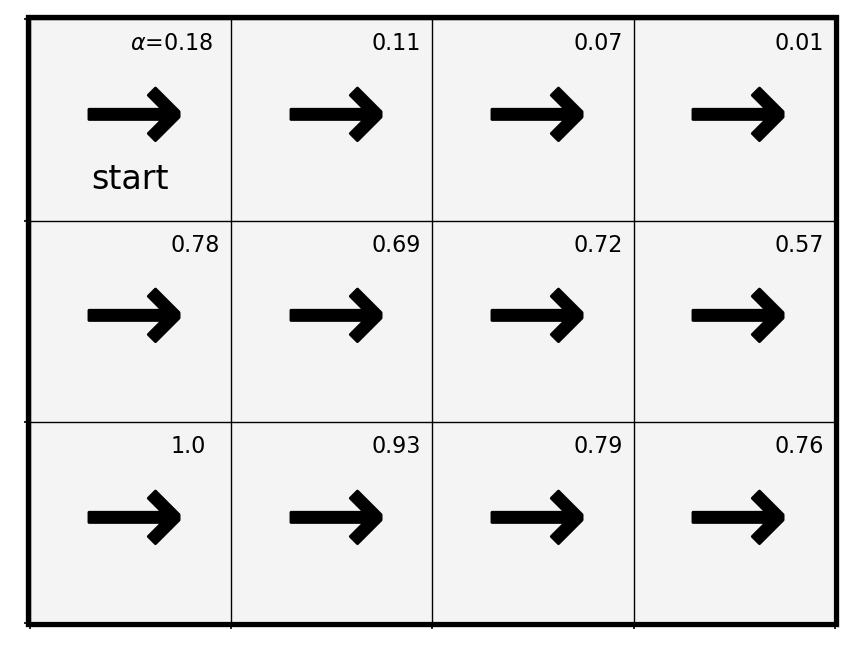

In [23]:
plot_policy(task,V,Pol_Dyn,core_states,Alpha=Alpha_Dyn)

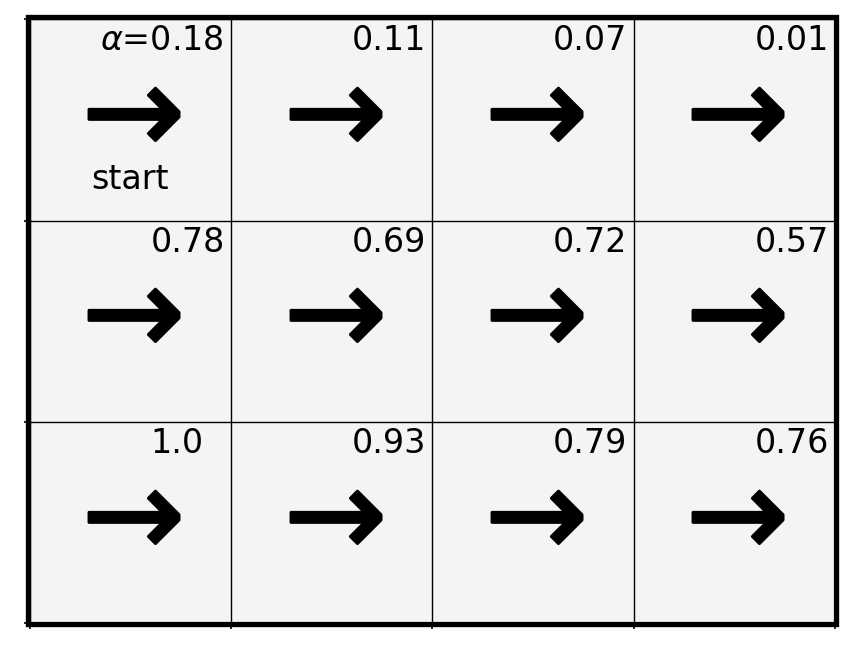

In [24]:
# bigger font for talk  
plot_policy(task,V,Pol_Dyn,core_states,Alpha=Alpha_Dyn,alpha_fontsize=12)

### fCVaR

In [42]:
# starting alpha 
alpha0 =  0.18329807

#### Calculate Optimal Policy

In [26]:
task = Task_GridWorld()

results = CVaR_DP(task,
                    T=T,
                    alpha_set = alpha_set,
                    alpha0=alpha0,
                    cvar_type='fCVaR',
                    parallel=True)

t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0


#### Filename

In [105]:
savename= '../results/task_gridworld_fCVaR_T='+str(T)+'_21_alphaset'+str(np.round(alpha0,2))+'.p'
print(savename)

../results/task_gridworld_fCVaR_T=40_21_alphaset0.18.p


#### Remove distortion weights to save space

In [ ]:
results.pop('Xis');

#### Save

In [108]:
pickle.dump(results, 
            open(savename, "wb" ) )

#### Load

In [106]:
results = pickle.load( open(savename, "rb" ) )

#### Sample Trajectories from Optimal Policy

In [56]:
s0 = 0
Nsims=20000
Nsims=5000

# get alpha indicator 
alpha0_i = np.where(alpha_set==alpha0)[0][0]
print(alpha_set[alpha0_i])

# run the MCMC for the changing policy 
results_mcmc = run_simulation(task,
                               results['pi'].copy(),  # must be states x actions x alphas x time-steps
                               T=T,
                               Nsims = Nsims,
                               s0 = s0,
                               alpha_i0= alpha0_i,
                               alpha_set = alpha_set,
                               Xis=None,
                               adjust_alpha=False)  

0.18329807


#### Save Trajectories

In [57]:
savename_mcmc = savename.replace('.p','_mcmc.p')
print(savename_mcmc)

../results/task_gridworld_fCVaR_T=40_21_alphaset0.18_mcmc.p


In [58]:
# save 
pickle.dump(results_mcmc, 
            open(savename_mcmc, "wb" ) )

#### Load Trajectories

In [59]:
results_mcmc = pickle.load( open(savename_mcmc, "rb" ) )

#### Printing value function and policy

In [61]:
# display value function
alpha_idx=np.where(alpha_set==alpha0)[0][0]
t = 0
V = results['V_CVaR'][core_states,alpha_idx,t]
V.reshape(task.maze.shape)

array([[ -1.6666,   0.489 ,   2.6731,   2.9482],
       [ -2.1152,  -2.3382,  -0.4238,   2.3622],
       [ -4.8369,  -7.5794, -10.2358,  -4.8561]])

In [63]:
# display optimal policy
Pol = results['pi'][core_states,:,alpha_idx,t]
Pol[:,1].reshape(task.maze.shape)

array([[1., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

#### Figure 6: Plotting policy

/kyb/agpd/cgagne/CVaR_TwoStep/twosteps_neurips2021/gridworld_simulations/notebooks/../code/plotting.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  color_set = np.array([sns.color_palette()[3],'k'])


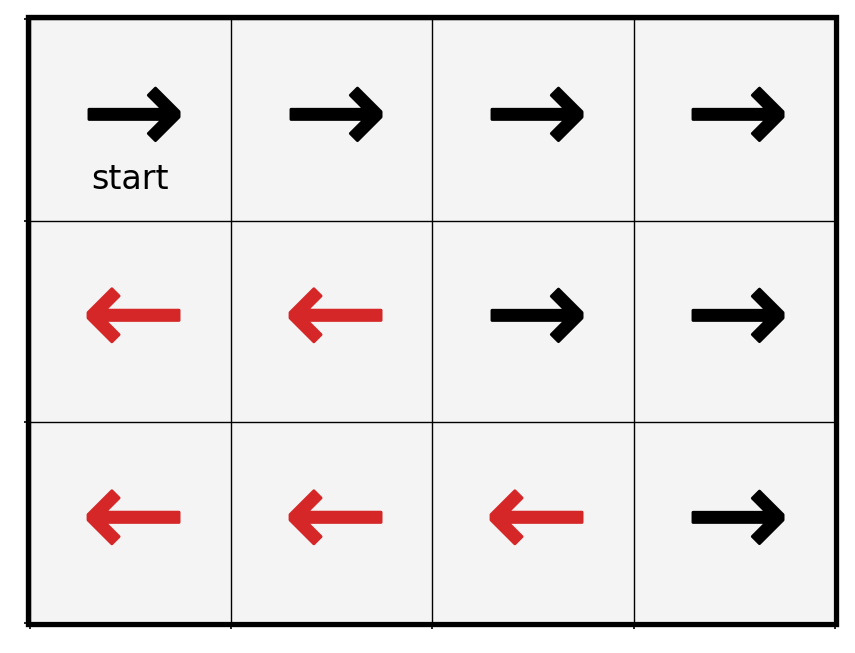

In [64]:
plot_policy(task,V,Pol,core_states,Alpha=None,asym_color=True)

### nCVaR

In [27]:
# starting alpha 
alpha0 =  0.18329807

#### Calculate Optimal Policy

In [28]:
task = Task_GridWorld()

results = CVaR_DP(task,
                    T=T,
                    alpha_set = alpha_set,
                    alpha0=alpha0,
                    cvar_type='nCVaR',
                    parallel=True)

t=39
t=38
t=37
t=36
t=35
t=34
t=33
t=32
t=31
t=30
t=29
t=28
t=27
t=26
t=25
t=24
t=23
t=22
t=21
t=20
t=19
t=18
t=17
t=16
t=15
t=14
t=13
t=12
t=11
t=10
t=9
t=8
t=7
t=6
t=5
t=4
t=3
t=2
t=1
t=0


#### Filename

In [29]:
savename= '../results/task_gridworld_nCVaR_T='+str(T)+'_21_alphaset.p'
print(savename)

../results/task_gridworld_nCVaR_T=40_21_alphaset.p


#### Remove distortion weights to save space

In [30]:
results.pop('Xis');

#### Save

In [31]:
pickle.dump(results, 
            open(savename, "wb" ) )

#### Load

In [32]:
results = pickle.load( open(savename, "rb" ) )

#### Sample Trajectories from Optimal Policy

In [33]:
s0 = 0
Nsims=20000
Nsims=5000

# get alpha indicator 
alpha0_i = np.where(alpha_set==alpha0)[0][0]
print(alpha_set[alpha0_i])

# run the MCMC for the changing policy 
results_mcmc = run_simulation(task,
                               results['pi'].copy(),  # must be states x actions x alphas x time-steps
                               T=T,
                               Nsims = Nsims,
                               s0 = s0,
                               alpha_i0= alpha0_i,
                               alpha_set = alpha_set,
                               Xis=None,
                               adjust_alpha=False)  

0.18329807


#### Save Trajectories

In [34]:
savename_mcmc = savename.replace('.p','_mcmc.p')
print(savename_mcmc)

../results/task_gridworld_nCVaR_T=40_21_alphaset_mcmc.p


In [35]:
# save 
pickle.dump(results_mcmc, 
            open(savename_mcmc, "wb" ) )

#### Load Trajectories

In [36]:
results_mcmc = pickle.load( open(savename_mcmc, "rb" ) )

In [37]:
np.sum(np.logical_and(np.logical_and(results_mcmc['states']!=12,
                      results_mcmc['states']!=13),results_mcmc['states']!=14),axis=0)

array([5000,  205, 4802, 4993, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000,
       5000, 5000, 5000, 5000, 5000, 5000, 5000])

#### Printing value function and policy

In [38]:
# display value function 
alpha_idx=np.where(alpha_set==alpha0)[0][0]
t = 0
V = results['V_CVaR'][core_states,alpha_idx,t]
V.reshape(task.maze.shape)

array([[-2.1351, -2.091 , -0.9323,  1.5035],
       [-2.6191, -3.5871, -4.0774, -0.4288],
       [-4.8369, -7.0547, -8.7886, -4.8561]])

In [39]:
# display optimal policy
Pol = results['pi'][core_states,:,alpha_idx,t]
Pol[:,1].reshape(task.maze.shape)

array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

#### Figure 6: plotting policy

/kyb/agpd/cgagne/CVaR_TwoStep/twosteps_neurips2021/gridworld_simulations/notebooks/../code/plotting.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  color_set = np.array([sns.color_palette()[3],'k'])


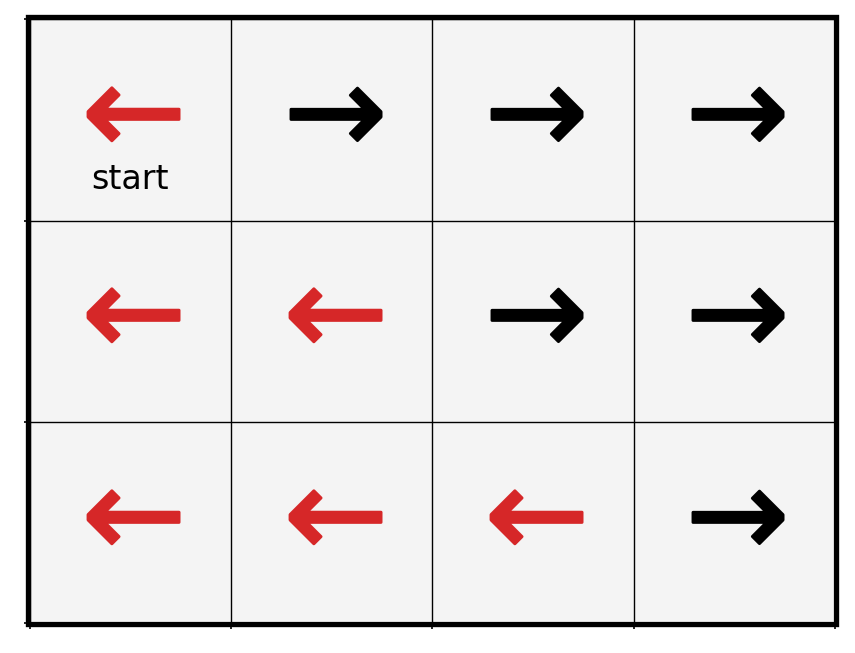

In [40]:
plot_policy(task,V,Pol,core_states,Alpha=None,asym_color=True)